<a href="https://colab.research.google.com/github/adarsh-saji/Deep_learning_projects/blob/main/Building_RESNET_and_classifying_blood_cell_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from keras.layers import Dense, Conv2D, MaxPooling2D, BatchNormalization, GlobalAvgPool2D, add, Activation, Input, ZeroPadding2D,Flatten
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.preprocessing import image
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from glob import glob
import numpy as np
from sklearn.metrics import confusion_matrix

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
IMAGE_SHAPE = [100,100]

In [ ]:
train_path = '/content/drive/MyDrive/images/TRAIN'
valid_path = '/content/drive/MyDrive/images/TEST'

In [ ]:
image_files = glob(train_path + '/*/*.jp*g')
valid_image_files = glob(valid_path + '/*/*.jp*g')

In [ ]:
folders = glob(train_path + '/*')

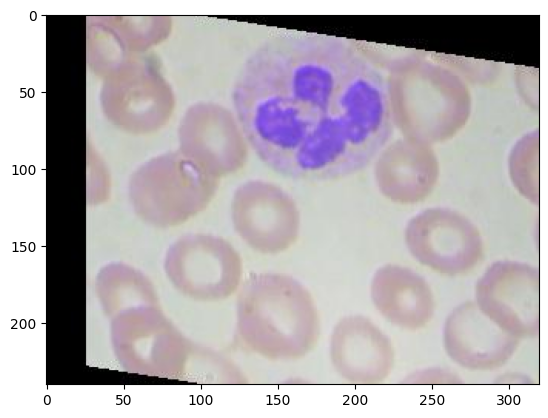

In [ ]:
plt.imshow(load_img(np.random.choice(image_files)))
plt.show()

In [ ]:
def identity_block(input_, filters, kernel_size):
    f1, f2, f3 = filters

    x = Conv2D(f1, (1, 1), kernel_initializer='he_normal')(input_)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(f2, kernel_size, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(f3, (1, 1), kernel_initializer='he_normal',kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = BatchNormalization()(x)

    shortcut_path = input_
    x = add([shortcut_path, x])
    x = Activation('relu')(x)

    return x


In [ ]:
def convulation_block(input_, filters, kernel_size, strides=(2, 2)):
    f1, f2, f3 = filters

    x = Conv2D(f1, (1, 1), strides=strides, kernel_initializer='he_normal',kernel_regularizer=tf.keras.regularizers.l2(0.01))(input_)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(f2, kernel_size, padding='same', kernel_initializer='he_normal',kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(f3, (1, 1), kernel_initializer='he_normal',kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = BatchNormalization()(x)

    shortcut_path = Conv2D(f3, (1, 1), strides=strides, kernel_initializer='he_normal',kernel_regularizer=tf.keras.regularizers.l2(0.01))(input_)
    shortcut_path = BatchNormalization()(shortcut_path)

    x = add([shortcut_path, x])
    x = Activation('relu')(x)

    return x


In [ ]:
# our custom resnet
i = Input(shape=IMAGE_SHAPE + [3])
x = ZeroPadding2D(padding=(3, 3))(i)
x = Conv2D(64, (7, 7),
           strides=(2, 2),
           padding='valid',
           kernel_initializer='he_normal',
           kernel_regularizer=tf.keras.regularizers.l2(0.01)
           )(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = ZeroPadding2D(padding=(1, 1))(x)
x = MaxPooling2D((3, 3), strides=(2, 2))(x)

x = convulation_block(x,[64,64,256],3)
x = identity_block(x, [64, 64, 256], 3)
x = identity_block(x, [64, 64, 256], 3)

"""x = convulation_block(x, [128, 128, 512],3)
x = identity_block(x, [128, 128, 512], 3)
x = identity_block(x, [128, 128, 512], 3)
x = identity_block(x, [128, 128, 512], 3)"""

x = Flatten()(x)
prediction = Dense(len(folders), activation='softmax')(x)

In [ ]:
model = Model(inputs = i, outputs = prediction)

In [ ]:
model.summary()

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['accuracy'])

In [ ]:
def preprocess_image2(x):
  x/= 127.5
  x-=1
  return x

In [ ]:
train_gen = ImageDataGenerator(
    rotation_range= 20,
    width_shift_range=0.20,
    height_shift_range=0.20,
    brightness_range=( 0.20,0.30),
    horizontal_flip= True,
    vertical_flip = True,
    preprocessing_function= preprocess_image2
)

test_gen = ImageDataGenerator(
    preprocessing_function= preprocess_image2
)

In [ ]:
val_gen = train_gen.flow_from_directory(valid_path, target_size= IMAGE_SHAPE, class_mode = 'sparse')
print(val_gen.class_indices)

label = [None] * len(val_gen.class_indices)
for class_name, index in val_gen.class_indices.items():
    label[index] = class_name

Found 2487 images belonging to 4 classes.
{'EOSINOPHIL': 0, 'LYMPHOCYTE': 1, 'MONOCYTE': 2, 'NEUTROPHIL': 3}


In [ ]:
train_generator = train_gen.flow_from_directory(
    train_path,
    batch_size= 64,
    target_size = IMAGE_SHAPE,
    class_mode = 'sparse',
    shuffle = True)

test_generator = test_gen.flow_from_directory(
    valid_path,
    batch_size= 64,
    class_mode = 'sparse',
    target_size = IMAGE_SHAPE,
    shuffle = True
)

Found 9957 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.


In [ ]:
r = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10,
    steps_per_epoch=len(image_files) //64,
    validation_steps=len(valid_image_files) // 64,
    validation_freq = 1
)

Epoch 1/10
155/155 [==============================] - 63s 397ms/step - loss: 8.2529 - accuracy: 0.8781 - val_loss: 130.1305 - val_accuracy: 0.2496
Epoch 2/10
155/155 [==============================] - 62s 397ms/step - loss: 8.0414 - accuracy: 0.8874 - val_loss: 112.4208 - val_accuracy: 0.2508
Epoch 3/10
155/155 [==============================] - 67s 432ms/step - loss: 7.8490 - accuracy: 0.8970 - val_loss: 69.1808 - val_accuracy: 0.2841
Epoch 4/10
155/155 [==============================] - 61s 396ms/step - loss: 7.6868 - accuracy: 0.8920 - val_loss: 96.7661 - val_accuracy: 0.2521
Epoch 5/10
155/155 [==============================] - 60s 387ms/step - loss: 7.4907 - accuracy: 0.8988 - val_loss: 60.8568 - val_accuracy: 0.3326
Epoch 6/10
155/155 [==============================] - 61s 390ms/step - loss: 7.3062 - accuracy: 0.9048 - val_loss: 82.9836 - val_accuracy: 0.2669
Epoch 7/10
155/155 [==============================] - 62s 399ms/step - loss: 7.1264 - accuracy: 0.9032 - val_loss: 81.4311

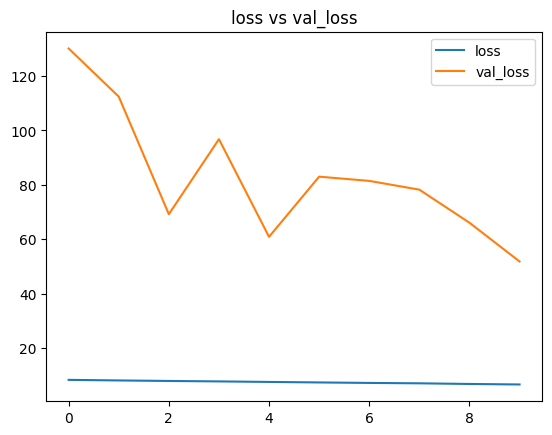

In [ ]:
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.title('loss vs val_loss')
plt.legend()
plt.show()

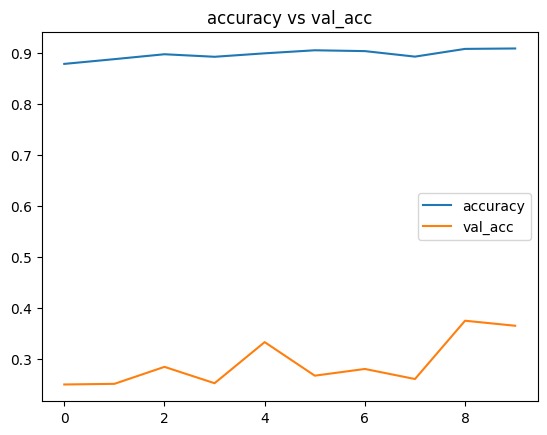

In [ ]:
plt.plot(r.history['accuracy'], label = 'accuracy')
plt.plot(r.history['val_accuracy'], label = 'val_acc')
plt.title('accuracy vs val_acc')
plt.legend()
plt.show()

In [ ]:
def get_confusion_matrix(data_path, N):
  # we need to see the data in the same order
  # for both predictions and targets
  print("Generating confusion matrix", N)
  predictions = []
  targets = []
  i = 0
  for x, y in val_gen.flow_from_directory(data_path, target_size=IMAGE_SIZE, shuffle=False, batch_size=batch_size * 2):
    i += 1
    if i % 50 == 0:
      print(i)
    p = model.predict(x)
    p = np.argmax(p, axis=1)
    y = np.argmax(y, axis=1)
    predictions = np.concatenate((predictions, p))
    targets = np.concatenate((targets, y))
    if len(targets) >= N:
      break

  cm = confusion_matrix(targets, predictions)
  return cm

In [ ]:
def get_confusion_matrix(val_gen, N):
    print("Generating confusion matrix", N)

    predictions = []
    targets = []
    i = 0

    for x, y in val_gen:
        i += 1
        if i % 50 == 0:
            print(i)

        p = model.predict(x)
        p = np.argmax(p, axis=1)

        # Use y directly as class labels
        targets = np.concatenate((targets, y))
        predictions = np.concatenate((predictions, p))

        if len(targets) >= N:
            break

    # Assuming y is already 1D (class labels)
    cm = confusion_matrix(targets, predictions)
    return cm

# Example usage
cm = get_confusion_matrix(val_gen, N=len(image_files))
print(cm)


Generating confusion matrix 9957
1/1 [==============================] - 0s 19ms/step
50
1/1 [==============================] - 0s 19ms/step
100
1/1 [==============================] - 0s 19ms/step
150
1/1 [==============================] - 0s 36ms/step
200
1/1 [==============================] - 0s 24ms/step
250
1/1 [==============================] - 0s 19ms/step
300
1/1 [==============================] - 0s 22ms/step
[[1693   89    4  719]
 [  23 2356   75   32]
 [ 593    4 1471  424]
 [ 605   78   39 1775]]
